## Setup

In [ ]:
!pip install simpleitk
!pip install --upgrade torchaudio torchdata torchtext
!pip install --upgrade pytorch-ignite
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time
from tqdm import tqdm
from pprint import pprint

from skimage import io, transform
from collections import OrderedDict

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

from torchvision import models
from torch.nn.functional import relu

import torchvision.transforms as tt
import albumentations as A

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Segmentation using U-net architecture

The dataset contains 3D prostate MR images (in .nii format) together with segmentation masks. They were obtained from Medical Segmentation Decathlon (MSD), a biomedical image analysis challenge [link](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2).

### Use monai for pre-processing before training

In [3]:
from glob import glob

import monai

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,ToTensord,Resized,Activations
)

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

### Define some transformation approaches

In [4]:
orig_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        ToTensord(keys=['image', 'label']),

     ]
)

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.)),    #adjust the contrast to allow a better visualization
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[256,256,11]),
        ToTensord(keys=['image', 'label'])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.)),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image', 'label'], spatial_size=[256,256,11]),
        ToTensord(keys=['image', 'label'])
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=['image']),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image'], spatial_size=[256,256,11]),
        ToTensord(keys=['image'])
    ]
)

In [5]:
in_dir = "./Task05_Prostate/"

image_files = sorted(glob(os.path.join(in_dir, "imagesTr", "*.nii.gz")))
mask_files = sorted(glob(os.path.join(in_dir, "labelsTr", "*.nii.gz")))
ts_files = sorted(glob(os.path.join(in_dir, "imagesTs", "*.nii.gz")))

from sklearn.model_selection import train_test_split
path_train_volumes, path_test_volumes,path_train_segmentation,path_test_segmentation = train_test_split(image_files,mask_files, test_size=0.1, random_state=0)

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = [{"image": image_name} for image_name in ts_files]

In [6]:
print(f"Train shape: {len(train_files)}\nVal shape: {len(val_files)}\nTest shape: {len(test_files)}")

Train shape: 28
Val shape: 4
Test shape: 16


### Get train, validation and test loader

In [7]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=4)

In [8]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)
print(f"Transform image shape: {test_patient['image'].shape}\n Original image shape: {orig_patient['image'].shape}")

Transform image shape: torch.Size([4, 2, 256, 256, 11])
 Original image shape: torch.Size([1, 384, 384, 11, 2])


### Visualization

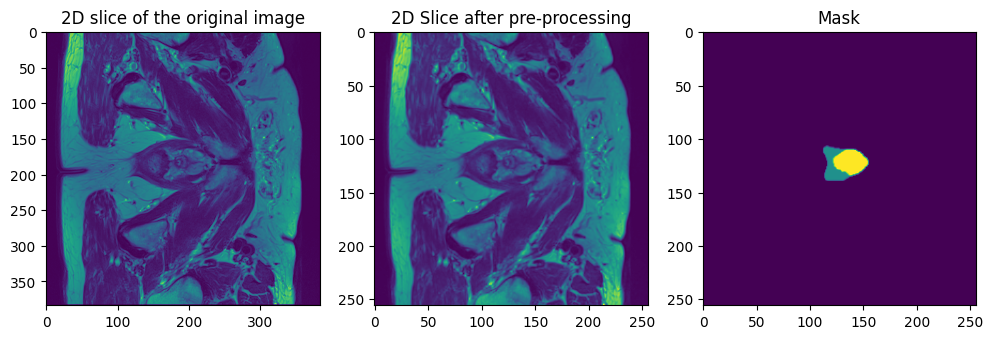

In [ ]:
plt.figure('test', (12, 6))
slice_num = 0
plt.subplot(1, 3, 1)
plt.title('2D slice of the original image')
plt.imshow(orig_patient['image'][0,: ,:,slice_num ,0])

plt.subplot(1, 3, 2)
plt.title('2D Slice after pre-processing')
plt.imshow(test_patient['image'][0,0,: ,: ,slice_num])

plt.subplot(1,3,3)
plt.title('Mask')
plt.imshow(test_patient['label'][0,0,: ,: ,slice_num])
plt.show()

In [ ]:
def create_gif(input_image, title=None, filename=None):

    import matplotlib.animation as animate
    images = []
    input_image_data = input_image
    fig = plt.figure()
    for i in range(len(input_image_data)):
        im = plt.imshow(input_image_data[i],cmap='gray', animated=True)
        images.append([im])

    ani = animate.ArtistAnimation(fig, images, interval=200, blit=True, repeat_delay=1000)
    plt.title(title, fontsize=20)
    plt.axis('off')
    ani.save(filename)
    plt.show()

In [ ]:
create_gif(test_patient['image'].permute(0,1,4,2,3)[0][0], title=None, filename="Prostate_MRI.gif")

### U-net architecture

In [9]:
class DoubleConv(nn.Module):

    '''
    This block consisting of two convolutional layers with batch normalization and ReLU activation after each convolution
    '''

    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super().__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Encoder(nn.Module):

    '''
    This class represents the encoder or downscaling block using max pooling followed by a double convolution block
    In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Decoder(nn.Module):

    '''
    This class represents the decoder/ upscaling block using transpose convolution, followed by a double convolution block
    In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image.
    To ensure
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):

        '''
        x2 represents the tensor from the encoder (downsampling) path.
        x1  is upsampled to match x2
        To make sure that the spatial dimensions (height and width) of x1 match those of x2, x1 is padded
        After x1 and x2 have the the same H and W, there are concatenation along the channel dimension
        The  values for padding are calculated based on the differences diffY and diffX [left, right, top, bottom]
        '''
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),nn.Softmax(dim=1))
            # nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):

    '''
    Custom class UNet is defined as a subclass of nn.Module.
    The __init__ method initializes the architecture of the U-Net by defining the layers for both the encoder and decoder parts of the network.
    The argument n_classes specifies the number of classes for the segmentation task.
    '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Encoder(64, 128)
        self.down2 = Encoder(128, 256)
        self.down3 = Encoder(256, 512)
        self.down4 = Encoder(512, 1024)

        self.up1 = Decoder(1024, 512)
        self.up2 = Decoder(512, 256)
        self.up3 = Decoder(256, 128)
        self.up4 = Decoder(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Loss function

In [11]:
def dice_coef_metric(pred, label,num_classes=3):
    smooth = 1e-8
    dice_scores = []
    pred = torch.argmax(pred,axis=1)
    label = label.type(torch.long)

    for id_class in range(num_classes):
      pred_class = (pred==id_class)
      mask_class = (label==id_class)
      intersection = 2.0 * (pred_class * mask_class).sum()
      union = pred_class.sum() + mask_class.sum() +smooth
      dice = intersection / union
      dice_scores.append(dice.item())
    # print(dice_scores)
    return np.mean(dice_scores)

def dice_coef_loss(pred, label):
    return 1 - dice_coef_metric(pred, label)

def bce_dice_loss(pred, label):
    label = label.type(torch.long)
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = F.cross_entropy(pred, label)
    return dice_loss + bce_loss

### Training and validation

In [12]:
model = UNet(2,3).to(device)

In [13]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 30
train_loss = []
val_loss = []
train_dice = []
val_dice = []
best_val_dice = 0
save_dir = './model/'


for epoch in range(epochs):
    model.train()
    running_train_loss = []
    running_val_loss = []
    running_train_dice = []
    running_val_dice = []


    for batch in tqdm(train_loader):
      images = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3) #(batchsize,channels,depth,height,width)
      masks = batch['label'].to(device,dtype=torch.float).permute(0,1,4,2,3)


      for i  in range(images.shape[2]):
        image = images[:,:,i,:,:]
        mask = masks[:,:,i,:,:].squeeze(1)
        outputs = model(image)

        loss = bce_dice_loss(outputs,mask)
        running_train_loss.append(loss.item())

        loss.backward()

        preds = outputs.clone()

        dice_ = dice_coef_metric(preds, mask)
        running_train_dice.append(dice_.item())

        optimizer.step()
        optimizer.zero_grad()



    model.eval()
    with torch.no_grad():
      for batch in val_loader:
        image = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)
        mask = batch['label'].to(device,dtype=torch.float).permute(0,1,4,2,3)

        for i  in range(image.shape[2]):
          img = image[:,:,i,:,:]
          masks = mask[:,:,i,:,:].squeeze(1)
          outputs = model(img)

          loss = bce_dice_loss(outputs,masks)
          running_val_loss.append(loss.item())

          preds = outputs.clone()

          dice = dice_coef_metric(preds, masks)
          running_val_dice.append(dice.item())



    epoch_train_loss = np.mean(running_train_loss)
    print('Train loss for epoch {}: {}'.format(epoch+1, epoch_train_loss))
    train_loss.append(epoch_train_loss)

    epoch_train_dice = np.mean(running_train_dice)
    print('Train dice metric for epoch {}: {}'.format(epoch+1, epoch_train_dice))
    train_dice.append(epoch_train_dice)

    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss for epoch {}: {}'.format(epoch+1, epoch_val_loss))
    val_loss.append(epoch_val_loss)

    epoch_val_dice = np.mean(running_val_dice)
    print('Validation dice metric for epoch {}: {}'.format(epoch+1, epoch_val_dice))
    val_dice.append(epoch_val_dice)

    #save the model if it is the best performing on the eval metric
    if epoch_val_dice>best_val_dice:
      best_val_dice = epoch_val_dice
      print(
            f"Saving new best performing model (dice_coefficient={best_val_dice})."
          )
      checkpoint_name = 'checkpoint_best_MSD.pth'
      checkpoint = {
          'nb_epochs_finished': epoch + 1,
          'model_state': model.state_dict(),
          'optimizer_state': optimizer.state_dict()
      }
      save_path = os.path.join(save_dir, checkpoint_name)
      torch.save(checkpoint, save_path)

100%|██████████| 7/7 [00:37<00:00,  5.29s/it]


Train loss for epoch 1: 1.7352564118125222
Train dice metric for epoch 1: 0.29800079474328955
Validation loss for epoch 1: 1.5398663499138572
Validation dice metric for epoch 1: 0.37956187521305046
Saving new best performing model (dice_coefficient=0.37956187521305046).


100%|██████████| 7/7 [00:28<00:00,  4.11s/it]


Train loss for epoch 2: 1.5641299610014086
Train dice metric for epoch 2: 0.37917566590328744
Validation loss for epoch 2: 1.4554324475201694
Validation dice metric for epoch 2: 0.4083992148269758
Saving new best performing model (dice_coefficient=0.4083992148269758).


100%|██████████| 7/7 [00:29<00:00,  4.21s/it]


Train loss for epoch 3: 1.4619639833252152
Train dice metric for epoch 3: 0.428943418984118
Validation loss for epoch 3: 1.3761522011323408
Validation dice metric for epoch 3: 0.46471838805838633
Saving new best performing model (dice_coefficient=0.46471838805838633).


100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


Train loss for epoch 4: 1.3702142083799684
Train dice metric for epoch 4: 0.48706782827918815
Validation loss for epoch 4: 1.352671904997392
Validation dice metric for epoch 4: 0.47370766693105293
Saving new best performing model (dice_coefficient=0.47370766693105293).


100%|██████████| 7/7 [00:28<00:00,  4.11s/it]


Train loss for epoch 5: 1.3224784321599192
Train dice metric for epoch 5: 0.513556115993236
Validation loss for epoch 5: 1.3461151664907283
Validation dice metric for epoch 5: 0.4692091922413304


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 6: 1.3024409978420703
Train dice metric for epoch 6: 0.517902624521715
Validation loss for epoch 6: 1.3486205447803845
Validation dice metric for epoch 6: 0.4598584135881428


100%|██████████| 7/7 [00:27<00:00,  4.00s/it]


Train loss for epoch 7: 1.2752226653037133
Train dice metric for epoch 7: 0.5318421101264628
Validation loss for epoch 7: 1.3287020596590908
Validation dice metric for epoch 7: 0.4713335584242349


100%|██████████| 7/7 [00:29<00:00,  4.16s/it]


Train loss for epoch 8: 1.259025504062702
Train dice metric for epoch 8: 0.5379766555822018
Validation loss for epoch 8: 1.3288566741076382
Validation dice metric for epoch 8: 0.46305624453463784


100%|██████████| 7/7 [00:28<00:00,  4.05s/it]


Train loss for epoch 9: 1.2440755940102912
Train dice metric for epoch 9: 0.5442000182055227
Validation loss for epoch 9: 1.3177019466053357
Validation dice metric for epoch 9: 0.46624404900340416


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 10: 1.2240133362931092
Train dice metric for epoch 10: 0.556430595626579
Validation loss for epoch 10: 1.3156036897139116
Validation dice metric for epoch 10: 0.46399260497877765


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 11: 1.230840616411977
Train dice metric for epoch 11: 0.5449706927159583
Validation loss for epoch 11: 1.306567202914845
Validation dice metric for epoch 11: 0.46586845947119104


100%|██████████| 7/7 [00:28<00:00,  4.06s/it]


Train loss for epoch 12: 1.193354598887555
Train dice metric for epoch 12: 0.5736681587829808
Validation loss for epoch 12: 1.2898422154513272
Validation dice metric for epoch 12: 0.4766202824098537
Saving new best performing model (dice_coefficient=0.4766202824098537).


100%|██████████| 7/7 [00:28<00:00,  4.11s/it]


Train loss for epoch 13: 1.1691621843870583
Train dice metric for epoch 13: 0.591278721850559
Validation loss for epoch 13: 1.2886371179060503
Validation dice metric for epoch 13: 0.47427088761645736


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 14: 1.1503618351824871
Train dice metric for epoch 14: 0.6038374992347528
Validation loss for epoch 14: 1.2645735523917458
Validation dice metric for epoch 14: 0.4912660925677329
Saving new best performing model (dice_coefficient=0.4912660925677329).


100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


Train loss for epoch 15: 1.1259207307518302
Train dice metric for epoch 15: 0.6225136564681668
Validation loss for epoch 15: 1.2632764902981846
Validation dice metric for epoch 15: 0.48836664082200243


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 16: 1.0938749305613629
Train dice metric for epoch 16: 0.6486056777759499
Validation loss for epoch 16: 1.2388606938448818
Validation dice metric for epoch 16: 0.5060537145614172
Saving new best performing model (dice_coefficient=0.5060537145614172).


100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


Train loss for epoch 17: 1.0734439809601029
Train dice metric for epoch 17: 0.6639961492516164
Validation loss for epoch 17: 1.2335875576192683
Validation dice metric for epoch 17: 0.5086632059943494
Saving new best performing model (dice_coefficient=0.5086632059943494).


100%|██████████| 7/7 [00:29<00:00,  4.23s/it]


Train loss for epoch 18: 1.063605398326725
Train dice metric for epoch 18: 0.6692295603623445
Validation loss for epoch 18: 1.2216582840139216
Validation dice metric for epoch 18: 0.5148508314494834
Saving new best performing model (dice_coefficient=0.5148508314494834).


100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


Train loss for epoch 19: 1.0421388234410967
Train dice metric for epoch 19: 0.6854857839361735
Validation loss for epoch 19: 1.1899721947583286
Validation dice metric for epoch 19: 0.5389622773862247
Saving new best performing model (dice_coefficient=0.5389622773862247).


100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


Train loss for epoch 20: 1.0152413210311493
Train dice metric for epoch 20: 0.707585500877802
Validation loss for epoch 20: 1.2043163017793135
Validation dice metric for epoch 20: 0.5223146324807947


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 21: 1.0078315247188916
Train dice metric for epoch 21: 0.7105187354165884
Validation loss for epoch 21: 1.188865141435103
Validation dice metric for epoch 21: 0.531780852174217


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Train loss for epoch 22: 0.9821145728036955
Train dice metric for epoch 22: 0.7316493472947188
Validation loss for epoch 22: 1.182994929226962
Validation dice metric for epoch 22: 0.5339777868128185


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Train loss for epoch 23: 0.9654256825323229
Train dice metric for epoch 23: 0.7440987996398208
Validation loss for epoch 23: 1.2012347416444258
Validation dice metric for epoch 23: 0.5142619512467222


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Train loss for epoch 24: 0.9681060259992426
Train dice metric for epoch 24: 0.7379372675965633
Validation loss for epoch 24: 1.1987508968873457
Validation dice metric for epoch 24: 0.5121975284507216


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 25: 0.963968656279824
Train dice metric for epoch 25: 0.7382737689377393
Validation loss for epoch 25: 1.154474594376304
Validation dice metric for epoch 25: 0.5529638063727003
Saving new best performing model (dice_coefficient=0.5529638063727003).


100%|██████████| 7/7 [00:28<00:00,  4.05s/it]


Train loss for epoch 26: 0.9470439259108011
Train dice metric for epoch 26: 0.7512190643843119
Validation loss for epoch 26: 1.1372625611045144
Validation dice metric for epoch 26: 0.5641646707486927
Saving new best performing model (dice_coefficient=0.5641646707486927).


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 27: 0.9294647365421443
Train dice metric for epoch 27: 0.7646459536505985
Validation loss for epoch 27: 1.1683906533501365
Validation dice metric for epoch 27: 0.5298795528484113


100%|██████████| 7/7 [00:28<00:00,  4.06s/it]


Train loss for epoch 28: 0.9078827268117434
Train dice metric for epoch 28: 0.7822099893607877
Validation loss for epoch 28: 1.1611736904491077
Validation dice metric for epoch 28: 0.534570018224644


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 29: 0.8991343812509016
Train dice metric for epoch 29: 0.7875067551269547
Validation loss for epoch 29: 1.1915343674746426
Validation dice metric for epoch 29: 0.5033011564025373


100%|██████████| 7/7 [00:27<00:00,  3.95s/it]


Train loss for epoch 30: 0.9033194695200238
Train dice metric for epoch 30: 0.7802109889911883
Validation loss for epoch 30: 1.1735268072648481
Validation dice metric for epoch 30: 0.5163077382427274


### Plot losses

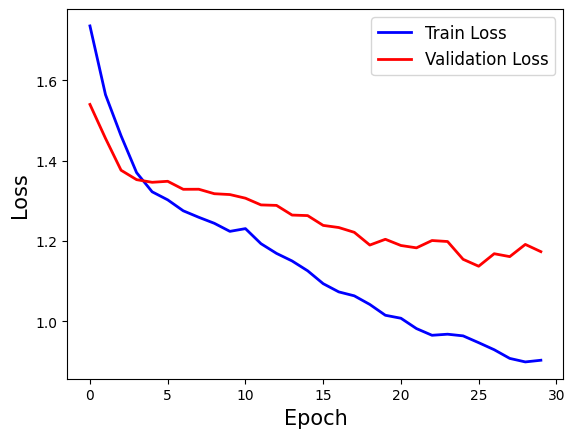

In [14]:
plt.plot(train_loss, label='Train Loss', lw=2, c="b")
plt.plot(val_loss,label='Validation Loss', lw=2, c="r")
plt.legend(fontsize=12);
plt.xlabel("Epoch", fontsize=15);
plt.ylabel("Loss", fontsize=15);

### Testing and Visualization of some predictions

In [ ]:
#load the best best model saved during the training
save_dir = "./model/"
checkpoint_name = "checkpoint_best_MSD.pth"
PATH = os.path.join(save_dir, checkpoint_name)
state_dict = torch.load(PATH, map_location=torch.device('cpu')) #If using cpu

model = UNet(2,3).to(device)

model.load_state_dict(state_dict['model_state'])
model.eval()

In [ ]:
test_patient = first(val_loader)
slice_num = 5
img = test_patient['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)[:,:,slice_num,:,:]
pred =  model(img)

pred = torch.argmax(pred,axis=1)
print(pred.unique())
pred = pred.detach().cpu().numpy()

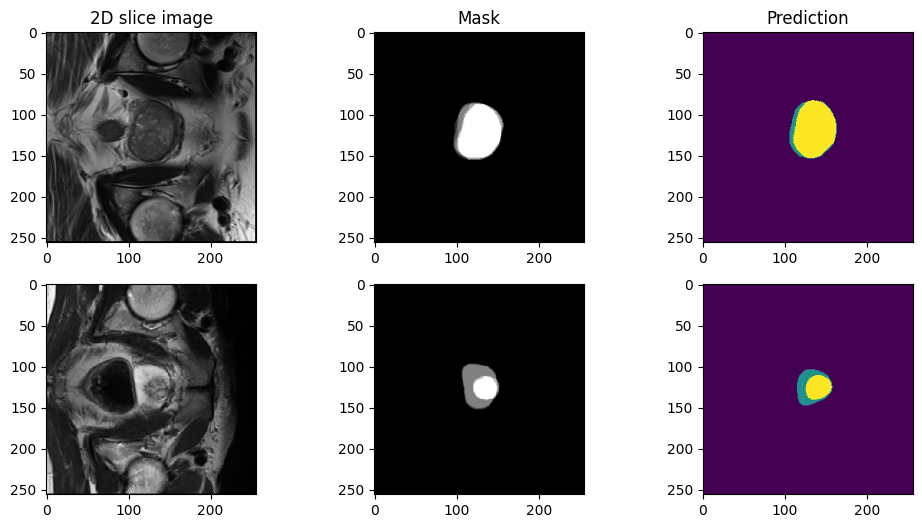

In [18]:
plt.figure('test', (12, 6))
i = 1

plt.subplot(2, 3, 1)
plt.title('2D slice image')
plt.imshow(test_patient['image'].permute(0,1,4,2,3)[i,0, slice_num,: ,:], cmap='gray')

plt.subplot(2,3,2)
plt.title('Mask')
plt.imshow(test_patient['label'].permute(0,1,4,2,3)[i,0, slice_num,: ,:],cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Prediction')
plt.imshow(pred[i])

plt.subplot(2, 3, 4)
plt.imshow(test_patient['image'].permute(0,1,4,2,3)[i+1,0, slice_num,: ,:], cmap='gray')

plt.subplot(2,3,5)
plt.imshow(test_patient['label'].permute(0,1,4,2,3)[i+1,0, slice_num,: ,:], cmap='gray')

plt.subplot(2, 3, 6)
plt.imshow(pred[i+1])
# plt.show()

#### Create mask for the test sample

In [19]:
pred_masks=[]
images = []
model.eval()
running_test_loss=[]

for batch in tqdm(test_loader):

  image = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)

  for i  in range(image.shape[2]):
    img = image[:,:,i,:,:]
    outputs = model(img)

    preds = outputs.clone()
    preds = torch.argmax(preds,axis=1)
    preds = preds.detach().cpu().numpy()
    pred_masks.append(preds)
    images.append(img.detach().cpu().numpy())

100%|██████████| 4/4 [00:26<00:00,  6.68s/it]


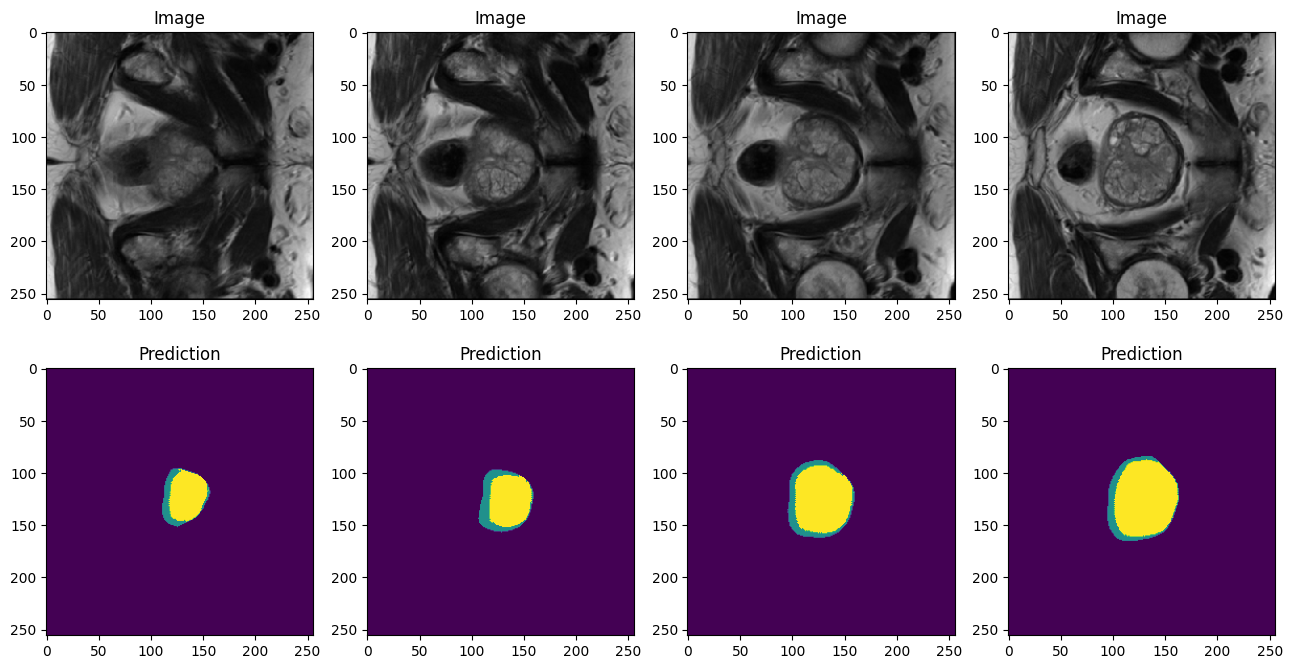

In [20]:
plt.figure('test', (20, 8))
n=5
j = 3
for i in range(1,n):
  plt.subplot(2, n, i)
  plt.title('Image')
  plt.imshow(images[i][j,0,:,:], cmap='gray')

  plt.subplot(2, n, n+i)
  plt.title('Prediction')
  plt.imshow(pred_masks[i][j])